# Regression


<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">

**Basi Fondamentali del Machine Learning**

Day 7 - 2024-11-7

Michael Wood, Maciej Sakwa, Emanuele Ogliari

![bouncy balls](images/bouncy_balls.webp)


## Outline

Part I
1. Machine Learning Project Structure (review)
2. Types of regression
3. Traditional approaches
   1. Time series decomposition
   2. Transformations
   3. Ensemble and Bayes

Part II
1. Machine learning approaches
   1. Neural networks
   2. Large neural networks 


## Learning obejctives

* Understand how a line can be fit to data in 2D and 3D
* See the analogy between a simple line fit and training a neural network
* Follow the math and reason for Mean Squared Error
* Gennerally follow how gradient descent and error backpropagation work

---

# Machine Learning Project Structure (review)

- ML is often called a **black-box**, but it's not a *magic* black-box
- You can not solve *any* problem using *any* data
- The data and model need to be appropriate for the problem
- General project structure is repeated
  - Data changes
  - Model changes

![structure](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/project-structure.png?raw=true)

## 1. Problem definition

**Predict the day-ahead JPL EV charging station power every day at midnight.**

|I/O|  Data | When|
| --- | --- | --- |
|Inputs| `charging_power` | day `d` |
|Target|  `charging_power` | day `d+1`|
|Output| `charging_power_est` | day `d+1` |



## 2. Data collection and engineering

Import the packages

In [1]:
from math import nan
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.plotting.backend='plotly'

def import_data(filepath):
    df = pd.read_csv(filepath,comment='#',index_col=0,parse_dates=True)
    df = df.rename(columns={'Load (kW)':'Load'})
    df = df.resample('1h').mean() # just to establish freq
    df = df['2018-10-15':'2020-2-28'] # cut out startup period and covid
    df[df.Load<0] = nan
    df = df.ffill()
    df = df/10
    df = df[df.index.weekday<4]
    return df.round(1)

def plot_superimpose(ds,days=1,dppd=24,alpha=0.1,title=None):
    pd.options.plotting.backend='matplotlib'
    overlaid = ds.values[:(days*dppd)*(len(ds)//(days*dppd))].reshape(-1,days*dppd).T
    idx = pd.date_range('2024-11-3 0:00',periods=days*dppd,freq='1h') # begin on any given monday
    overlaid = pd.DataFrame(overlaid,index=idx)
    if days==1:
        plt.figure(figsize=(7,5))
    else:
        plt.figure(figsize=(12,5))
    plt.plot(overlaid,alpha=alpha)
    if days==1:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('Day %w %H:%M'))
    if title is not None:
        plt.title(title)
    plt.ylabel('kW')
    plt.show()
    pd.options.plotting.backend='plotly'
    

Total station EV charging power, from the US Jet Propulsion Lab (JPL)

In [2]:
data = import_data('data/ev_charging_station.csv')
data['2019-4-8':'2019-4-11'].plot(title='EV Charging Station Power')

Summary statistics

In [3]:
data.describe()

,Load
count,6912.000000
mean,19.873380
std,23.612089
min,0.000000
25%,0.000000
50%,7.400000
75%,33.900000
max,74.200000


Find statistical outliers

In [4]:
data['LoadRaw'] = data.Load

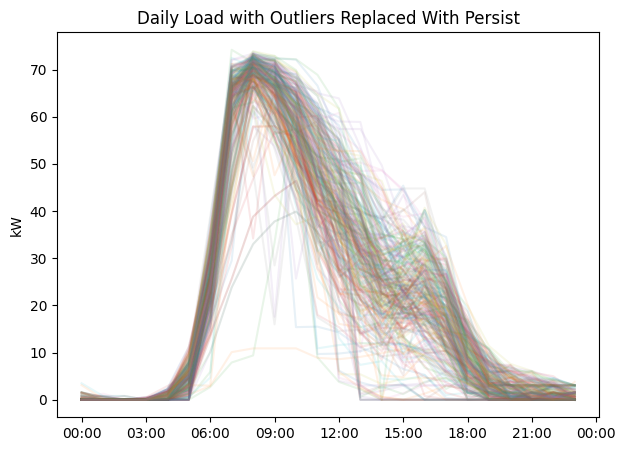

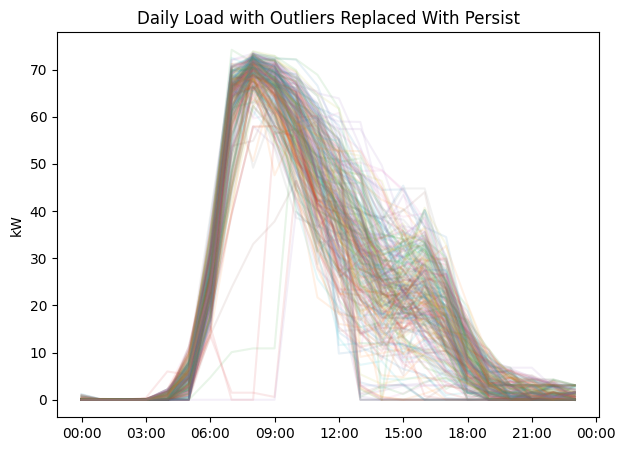

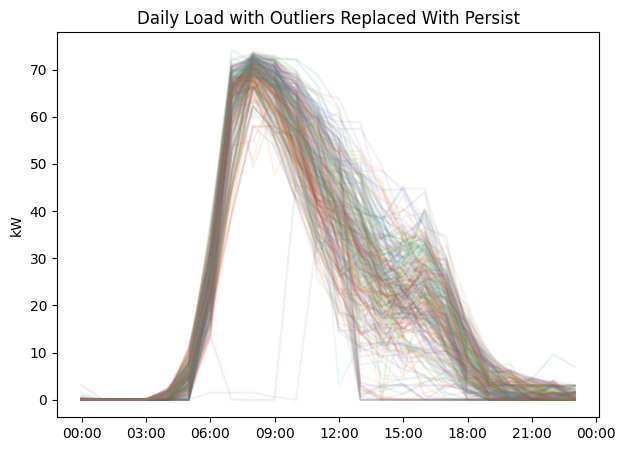

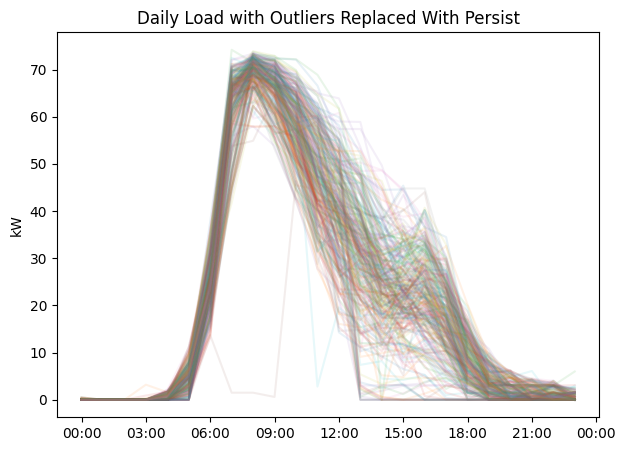

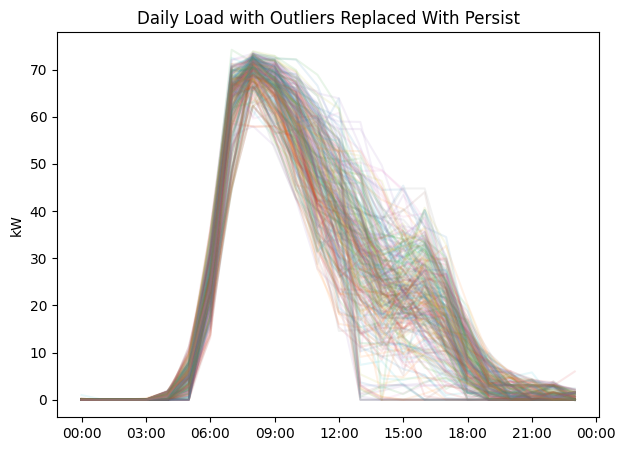

In [5]:
for d in [2,3,4,5,6]:
    x = data.Load
    persist = data.LoadRaw.shift(d*24).rename(f'{d}d').to_frame()
    #data['persist'] = data.LoadRaw.shift(d*24)
    xDaily = x.values[:24*(len(x)//24)].reshape(-1,24)
    xDaily = pd.DataFrame(xDaily)
    
    z = (xDaily - xDaily.mean())/xDaily.std()
    data['zscore'] = z.values.flatten()

    data['Load'] = x
    data.loc[data.zscore.abs()>2.5,'Load'] = nan

    data.loc[data.Load.isna().values,'Load'] = persist.loc[data.Load.isna().values,f'{d}d']
    plot_superimpose(data.Load,title='Daily Load with Outliers Replaced With Persist')

Previously we used *correlation* to compare features.

*Autocorrelation* is the correlation between the data, and the *lagged* or shifted version. It measures linear similarity over time.

E.g.

- `corr( data, data.shift('1h') )` 
- `corr( data, data.shift('24h') )`

In [6]:
data['Persist_1day'] = data.Load.shift(24)
data.plot(x='Persist_1day',y='Load',kind='scatter',title='Autocorrelation (1 day)')

1 is perfect correlation, 0 is perfect *uncorrelation*

-1 is perfect *inverse* correlation (A goes up, B goes down)

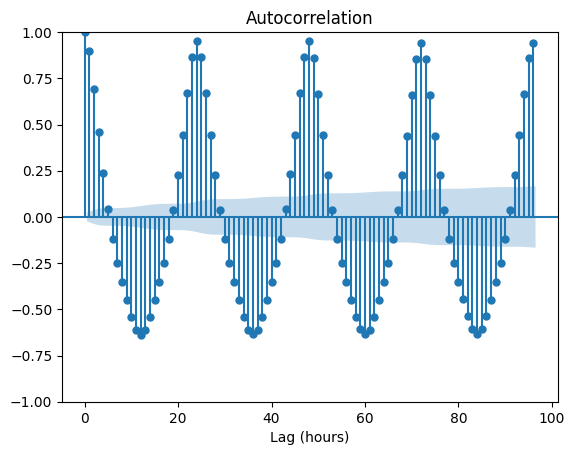

In [7]:
plot_acf(data.Load, lags=4*24);
plt.xlabel('Lag (hours)');
plt.show()

Remember in supervised learning:
- Inputs are **features**
- Outputs are what _do_ come out of the model
- What we _want_ from the model are **targets** (or labels)

In our case, we want to estimate the actual energy price using the generation data, let's extract the corresponding columns:

In [8]:
from pandas import Timedelta as td
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.simplefilter(action='ignore', category=UserWarning)

def calc_mae(y_true,y_pred):
    return (y_true-y_pred).abs().mean()

pdq=[1,1,1]
PDQ=[1,1,1]
train_days=1
pred_days=1
test_start_day=30
method='newton'

train_start = test_start_day*24 - train_days*24
test_end    = test_start_day*24 + pred_days*24

df_offset = data[train_start:test_end].copy()
df_offset['real_index'] = df_offset.index
df_offset.index = pd.date_range(df_offset.index[0],
                                periods=len(df_offset),
                                freq='1h')

train_start = df_offset.index[0]
train_end   = train_start + td(days=train_days) - td(hours=1)

test_start = train_end  + td(hours=1)
test_end   = test_start + td(days=pred_days) - td(hours=1)

train = df_offset[train_start:train_end].copy().drop('real_index',axis=1)
test  = df_offset[test_start:test_end  ].copy().drop('real_index',axis=1)

model = SARIMAX(train.Load,
                #exog=train.exog,
                order=pdq,
                seasonal_order=PDQ+[24],
                method=method)

model_fit = model.fit( disp=0 )

train['sarimax'] = model_fit.predict(   start=train_start,
                                        end=train_end,
                                        #exog=train.exog
                                        )

train.index = df_offset[train_start:train_end].real_index

test['sarimax'] = model_fit.predict(    start=test_start,
                                        end=test_end,
                                        #exog=test.exog,
                                        )

test.index = df_offset[test_start:test_end].real_index

mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.sarimax),
                           'persist':calc_mae(train.Load,train.Persist_1day)}),
            'test':dict({  'sarimax':calc_mae(test.Load,test.sarimax),
                           'persist':calc_mae(test.Load,test.Persist_1day)})})

skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})

df_forecast = pd.concat([train[['Load','Persist_1day']],
                         test[['Load','Persist_1day']]],        axis=0)

df_forecast = pd.concat([df_forecast,
                         train.sarimax.rename('train_sarimax'),
                         test.sarimax.rename('test_sarimax')],  axis=1)

skill['test']

0.0

For now we don't do any modifications to the **features** we have in the dataset, let's see what results we get with almost *raw* data.

## 3. Model build and train

In [9]:
from pandas import Timedelta as td
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.simplefilter(action='ignore', category=UserWarning)

def calc_mae(y_true,y_pred):
    return (y_true-y_pred).abs().mean()
from sklearn.preprocessing import MinMaxScaler

Split the inputs and the labels in train and test subgroups

In [10]:
pdq=[1,1,1]
PDQ=[1,1,1]
train_days=1
pred_days=1
test_start_day=30
method='newton'

train_start = test_start_day*24 - train_days*24
test_end    = test_start_day*24 + pred_days*24

df_offset = data[train_start:test_end].copy()
df_offset['real_index'] = df_offset.index
df_offset.index = pd.date_range(df_offset.index[0],
                                periods=len(df_offset),
                                freq='1h')

train_start = df_offset.index[0]
train_end   = train_start + td(days=train_days) - td(hours=1)

test_start = train_end  + td(hours=1)
test_end   = test_start + td(days=pred_days) - td(hours=1)

train = df_offset[train_start:train_end].copy().drop('real_index',axis=1)
test  = df_offset[test_start:test_end  ].copy().drop('real_index',axis=1)

Create model with training data:

In [11]:
model = SARIMAX(train.Load,
                #exog=train.exog,
                order=pdq,
                seasonal_order=PDQ+[24],
                method=method)

Train (`fit`) the model to estimate the targets given the inputs:

In [12]:
model_fit = model.fit( disp=0 )

First we can call the `.predict()` method with *train* inputs:

In [13]:
train['sarimax'] = model_fit.predict(   start=train_start,
                                        end=train_end,
                                        #exog=train.exog
                                        )

train.index = df_offset[train_start:train_end].real_index

Then we `.predict()` the *test* inputs:

In [14]:
test['sarimax'] = model_fit.predict(    start=test_start,
                                        end=test_end,
                                        #exog=test.exog,
                                        )

test.index = df_offset[test_start:test_end].real_index

Finally evaluate the results:

In [15]:
mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.sarimax),
                           'persist':calc_mae(train.Load,train.Persist_1day)}),
            'test':dict({  'sarimax':calc_mae(test.Load,test.sarimax),
                           'persist':calc_mae(test.Load,test.Persist_1day)})})

skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})

skill['test']

0.0

In [16]:
train

,Load,LoadRaw,zscore,Persist_1day,sarimax
real_index,,,,,
2018-12-04 00:00:00,0.0,0.0,-0.294094,0.0,0.0
2018-12-04 01:00:00,0.0,0.0,NaN,0.0,0.0
2018-12-04 02:00:00,0.0,0.0,NaN,0.0,0.0
2018-12-04 03:00:00,0.0,0.0,-0.086332,0.0,0.0
2018-12-04 04:00:00,0.0,0.0,-0.695260,0.5,0.0
2018-12-04 05:00:00,3.4,3.4,-0.457438,5.0,0.0
2018-12-04 06:00:00,20.3,20.3,-1.012928,22.3,3.4
2018-12-04 07:00:00,49.2,49.2,-1.756687,59.6,20.3
2018-12-04 08:00:00,66.0,66.0,-0.692886,69.0,49.2


We can quickly visualise the results with a plot (we can declare it in a function to quickly reuse it later):

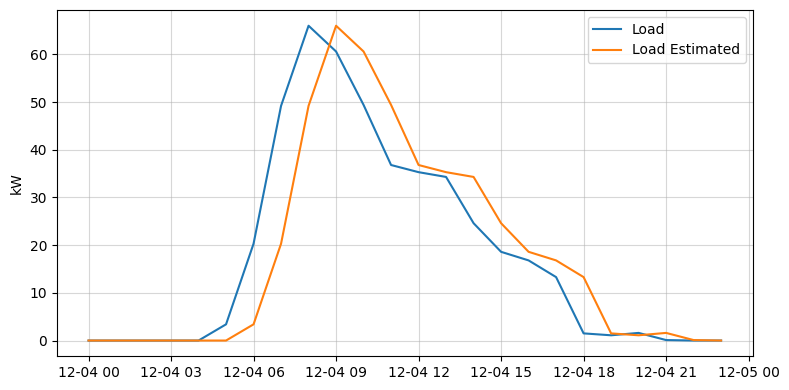

In [41]:
plt.figure(figsize=(8, 4))

plt.plot(train.Load, label='Load')
plt.plot(train.sarimax, label='Load Estimated')

plt.ylabel('kW')
plt.grid(which='major', alpha = 0.5)

plt.legend()
plt.tight_layout()
plt.show()

## 4. Evaluate results

We want to evaluate the model(s) using metrics that help us make a decision.

First, for notation:
- $y_{true}$ are the true values (`test_labels` in our case)
- $y_{pred}$ are the predicted values

We'll use one error metric:

* mean absolute error: $ MAE = |y_{true}-y_{pred}| $ 

And skill:

* $Skill = 1-\frac{error_{model}}{error_{benchmark}}$

Where the model error is our sarimax and the benchmark is 1-day persistence

In [18]:
mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.sarimax),
                           'persist':calc_mae(train.Load,train.Persist_1day)}),
            'test':dict({  'sarimax':calc_mae(test.Load,test.sarimax),
                           'persist':calc_mae(test.Load,test.Persist_1day)})})

skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})

skill['test']

0.0

---

# Types of regression

## Linear vs non-linear regression

Linear
- 2d: $y = wx + b$
- 3d: $y = w_1 x_1 + w_2 x_2 + b$

![linreg](images/linreg.png)

Non-linear
- Polynomial 2° 2d: $y = wx^2 + b$
- Polynomial 3° 2d: $y = wx^3 + wx^2 + b$
- Exponential: $y = w_0e^{w_1x} + b$

![linreg](images/polyreg.png)


## Interpolation vs extrapolation

Interpolation
- Common use is for filling in missing or outlier data
- What might `price actual` be if `price_day_ahead=40`?

![interpolate](images/interpolate.png)

Extrapolation
- Common use is to "extend" to model in a new direction
  - e.g. future, past, higher prices
- What might `price actual` be if `price_day_ahead=67.5`?

![extrapolate](images/extrapolate.png)

## Autoregression

Single Output

- Only predict one value (red `x`) at each step
- "Recursively" predict future steps
- $y_t = w_1 x_{t-1} + w_2 x_{t-2} + w_3 x_{t-3} + w_4 x_{t-4}$

| |  Inputs | Output|
| --- | --- | --- |
|Step 1| 4 `past` blue dots | first `pred` red dot |
|Step 2| 3 `past` blue dots _and_ first `pred` red dot | second `pred` red dot |
|Step 3| 2 `past` blue dots _and_ first 2 `pred` red dots | third `pred` red dot |


![multistep](images/autoregression_multistep.gif)

Multiple Output

- Predict any number of values in one step

![autoregression](images/autoregression.gif)

## Univariate vs multivariate

Univariate
- One input

| |  Data |
| --- | --- |
|Input| `charging power` | 
|Target|  `charging power` | 
|Output| `charging power estimate` | 

Multivariate
- Multiple inputs

| |  Data |
| --- | --- |
|Inputs| `charging power`, `air temperature` | 
|Target|  `charging power` | 
|Output| `charging power estimate` | 


## Endogenous vs exogenous features

Endogenous data
- From "inside" the system
- All data is generated from the same activity of charging EVs

| |  Data |
| --- | --- |
|Inputs| `charging power`, `number of EVs connected` | 
|Target|  `charging power` | 
|Output| `charging power estimate` | 

Exogenous data
- From "outside" the system
- Temperature is _related_ to, but is not interdependent on EV charging power

| |  Data |
| --- | --- |
|Inputs| `charging power`, `air temperature` | 
|Target|  `charging power` | 
|Output| `charging power estimate` | 


---
# Feature Engineering

## Transformations

Log

In [68]:
import numpy as np
data['Log_Transform'] = np.log(data['Persist_1day'].ffill()+1)
data = (data-data.min())/(data.max()-data.min())

corr = data.corr()['Load']['Log_Transform']
corr
data[['Load','Log_Transform']][24:4*24].plot(title=f'Correlation={corr:.3f}')

Square root

In [91]:
import numpy as np
data['Root_Transform'] = (data['Persist_1day'].ffill()+1)**0.5
data = (data-data.min())/(data.max()-data.min())

corr = data.corr()['Load']['Root_Transform']
corr
data[['Load','Root_Transform']][24:4*24].plot(title=f'Correlation={corr:.3f}')

Power transform

In [90]:
data['Root_Transform'] = (data['Persist_1day'].ffill()+1)**0.7
data = (data-data.min())/(data.max()-data.min())

corr = data.corr()['Load']['Root_Transform']
corr
data[['Load','Root_Transform']][24:4*24].plot(title=f'Correlation={corr:.3f}')

## Time series decomposition

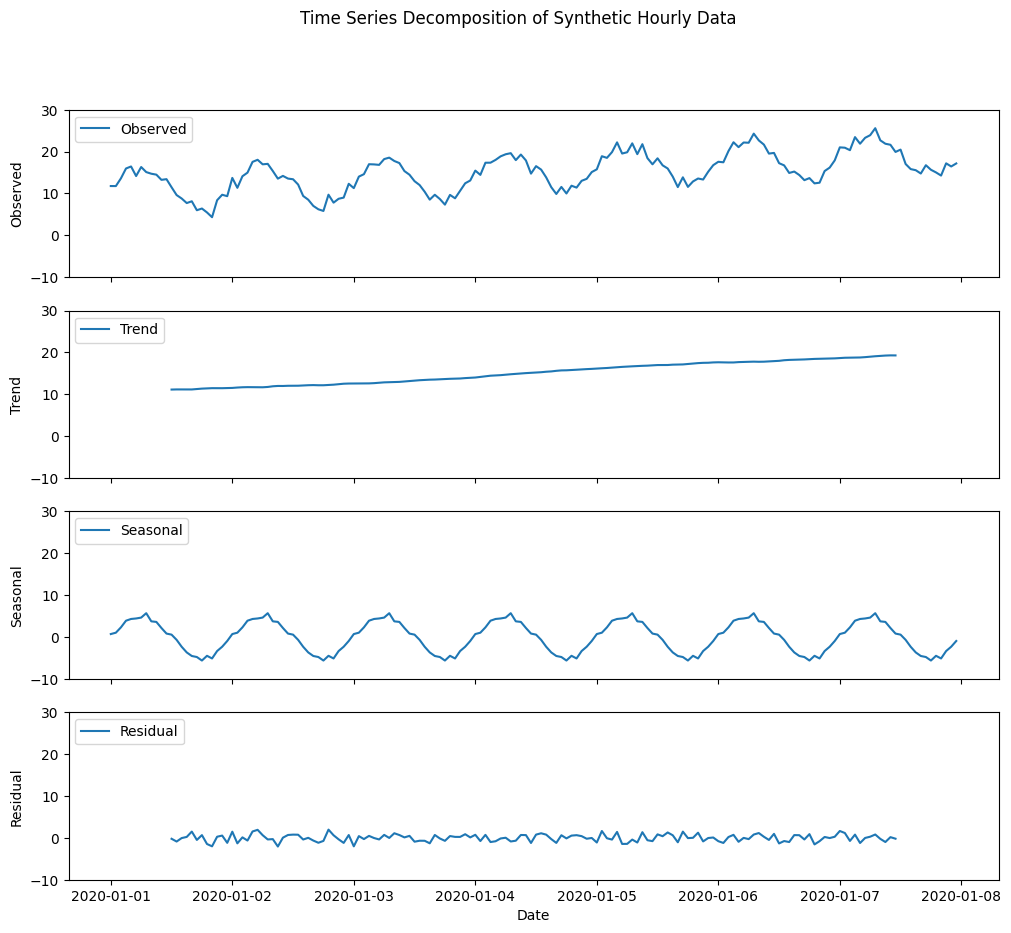

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Generate synthetic hourly time series data
np.random.seed(0)
date_range = pd.date_range(start='2020-01-01', periods=24*7, freq='H')  # 30 days of hourly data
trend = np.linspace(10, 20, 24*7)  # Linear trend
seasonal = 5 * np.sin(2 * np.pi * date_range.hour / 24)  # Daily seasonality
residual = np.random.normal(0, 1, 24*7)  # Random noise
synthetic_data = trend + seasonal + residual

# Create a pandas Series
data_synthetic = pd.Series(synthetic_data, index=date_range, name='Synthetic Load')

# Perform time series decomposition
decomposition = seasonal_decompose(data_synthetic, model='additive', period=24)  # Daily seasonality

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

ax1.plot(decomposition.observed, label='Observed')
ax1.legend(loc='upper left')
ax1.set_ylabel('Observed')
ax1.set_ylim(-10,30)

ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')
ax2.set_ylim(-10,30)

ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-10,30)

ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')
ax4.set_ylim(-10,30)

plt.suptitle('Time Series Decomposition of Synthetic Hourly Data')
plt.show()

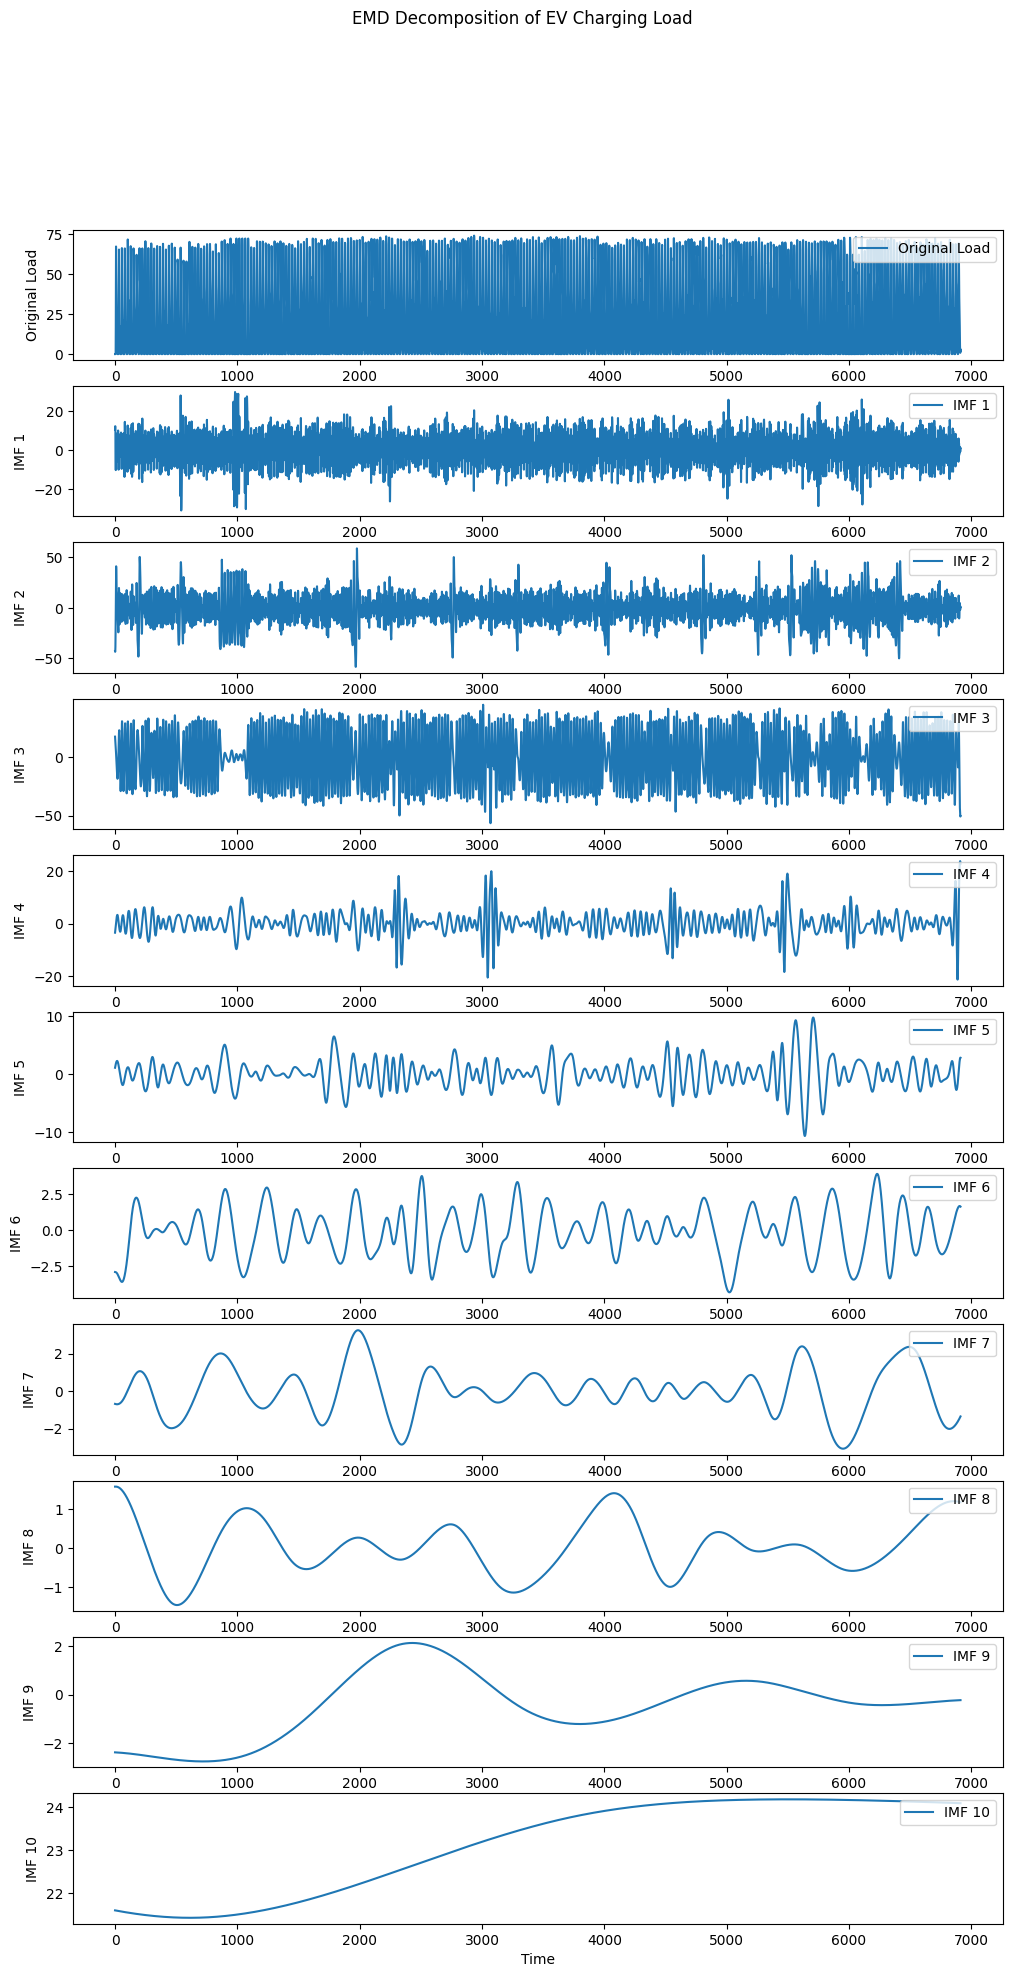

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD

# Assuming data['Load'] is a pandas Series
load_series = data['Load'].values

# Perform EMD decomposition
emd = EMD()
imfs = emd.emd(load_series)

# Plot the IMFs
num_imfs = imfs.shape[0]
fig, axes = plt.subplots(num_imfs + 1, 1, figsize=(12, 2 * (num_imfs + 1)))

axes[0].plot(load_series, label='Original Load')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('Original Load')

for i in range(num_imfs):
    axes[i + 1].plot(imfs[i], label=f'IMF {i + 1}')
    axes[i + 1].legend(loc='upper right')
    axes[i + 1].set_ylabel(f'IMF {i + 1}')

axes[-1].set_xlabel('Time')

plt.suptitle('EMD Decomposition of EV Charging Load')
plt.show()

In [34]:
data_imfs=pd.DataFrame(imfs.T)
data_imfs['Load'] = data['Load'].values
data_imfs.corr()[['Load']]

,Load
0,0.011188
1,0.442473
2,0.775038
3,0.056536
4,0.032730
5,0.034249
6,0.018351
7,0.015672
8,0.061806
9,0.060856


# Ensemble

## Mean

In [104]:
def sarimax_train_and_predict(pdq,PDQ,train_days=7):
    pred_days=1
    test_start_day=30
    method='newton'

    train_start = test_start_day*24 - train_days*24
    test_end    = test_start_day*24 + pred_days*24

    df_offset = data[train_start:test_end].copy()
    df_offset['real_index'] = df_offset.index
    df_offset.index = pd.date_range(df_offset.index[0],
                                    periods=len(df_offset),
                                    freq='1h')

    train_start = df_offset.index[0]
    train_end   = train_start + td(days=train_days) - td(hours=1)

    test_start = train_end  + td(hours=1)
    test_end   = test_start + td(days=pred_days) - td(hours=1)

    train = df_offset[train_start:train_end].copy().drop('real_index',axis=1)
    test  = df_offset[test_start:test_end  ].copy().drop('real_index',axis=1)

    model = SARIMAX(train.Load,
                    #exog=train.exog,
                    order=pdq,
                    seasonal_order=PDQ+[24],
                    method=method)

    model_fit = model.fit( disp=0 )

    train['sarimax'] = model_fit.predict(   start=train_start,
                                            end=train_end,
                                            #exog=train.exog
                                            )

    train.index = df_offset[train_start:train_end].real_index

    test['sarimax'] = model_fit.predict(    start=test_start,
                                            end=test_end,
                                            #exog=test.exog,
                                            )

    test.index = df_offset[test_start:test_end].real_index

    mae = dict({'train':dict({ 'sarimax':calc_mae(train.Load,train.sarimax),
                            'persist':calc_mae(train.Load,train.Persist_1day)}),
                'test':dict({  'sarimax':calc_mae(test.Load,test.sarimax),
                            'persist':calc_mae(test.Load,test.Persist_1day)})})

    skill = dict({  'train':round(1-mae['train']['sarimax']/mae['train']['persist'],3),
                    'test':round( 1-mae['test' ]['sarimax']/mae['test' ]['persist'],3)})
    
    return train, test, skill

In [105]:
train1,test1,skil1l = sarimax_train_and_predict(pdq=[1,1,1],PDQ=[1,1,1])
train2,test2,skil12 = sarimax_train_and_predict(pdq=[1,0,1],PDQ=[1,0,1])
train3,test3,skil13 = sarimax_train_and_predict(pdq=[3,1,2],PDQ=[1,0,1])

In [106]:
test_ensemble = (test1.sarimax + test2.sarimax + test3.sarimax)/3

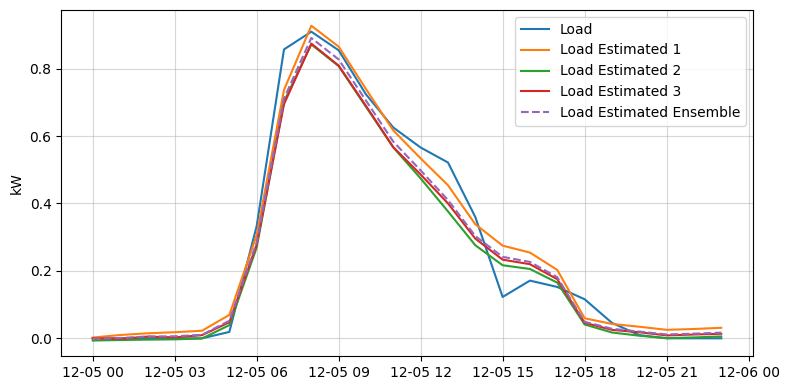

In [107]:
plt.figure(figsize=(8, 4))

plt.plot(test1.Load, label='Load')
plt.plot(test1.sarimax, label='Load Estimated 1')
plt.plot(test2.sarimax, label='Load Estimated 2')
plt.plot(test3.sarimax, label='Load Estimated 3')
plt.plot(test_ensemble, label='Load Estimated Ensemble',linestyle='--')

plt.ylabel('kW')
plt.grid(which='major', alpha = 0.5)

plt.legend()
plt.tight_layout()
plt.show()

## Bayes

$X_t^{opt} = X_t^{pred} Y_t$



- All letters are probability distributions

- Multiplying two probability distributions together is like finding the "union" of the two

- $X_t^{pred}$ is next estimated car position

- $Y$ is measured car position 

- $X_t^{opt}$ is optimal estimate of current car position 

![kalman](images/kalman.png)

Shortcut: product of two normal PDFs with only
- mean $\mu$, and
- standard deviation $\sigma$

$$
\mu_{opt} = {\mu_X \sigma_Y^2 + \mu_Y \sigma_X^2 \over \sigma_X^2 + \sigma_Y^2}, \ \ \ \  \sigma_{opt} =  {\sigma_X^2 \sigma_Y^2 \over \sigma_X^2 + \sigma_Y^2} \\
$$





In [170]:
x = data.Load/data.Load.max()
xDaily = x.values[:24*(len(x)//24)].reshape(-1,24)
xDaily = pd.DataFrame(xDaily,columns=[f'h{x}' for x in range(24)])

x_means = xDaily.mean()
x_stds = xDaily.std()

In [165]:
train,test,skil1 = sarimax_train_and_predict(pdq=[1,1,1],PDQ=[1,1,1])

In [171]:
test['x_means'] = x_means.values

In [172]:
errors = train.Load - train.sarimax

yDaily = errors.values[:24*(len(errors)//24)].reshape(-1,24)
yDaily = pd.DataFrame(yDaily,columns=[f'h{x}' for x in range(24)])

y_means = yDaily.mean()
y_stds = yDaily.std()

In [173]:
y_means = y_means + test.sarimax.values

In [174]:
opt_means = (x_means + y_stds**2 + y_means * x_stds**2) / (x_stds**2 + y_stds**2)
test['Bayes'] = opt_means.values
test = test/test.max()

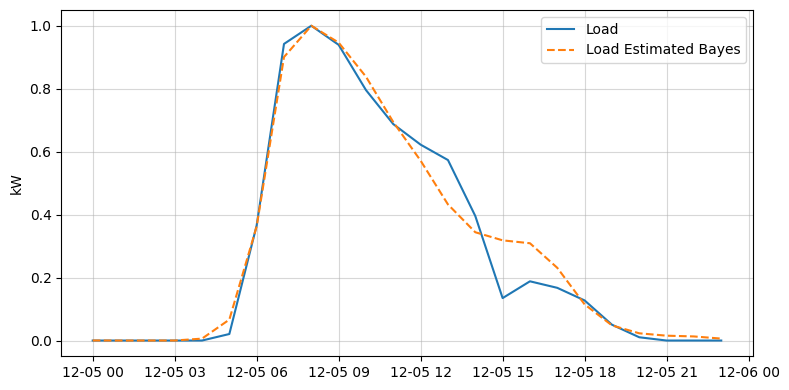

In [175]:
plt.figure(figsize=(8, 4))

plt.plot(test.Load, label='Load')
plt.plot(test.x_means, label='Load Estimated Bayes',linestyle='--')

plt.ylabel('kW')
plt.grid(which='major', alpha = 0.5)

plt.legend()
plt.tight_layout()
plt.show()

---
# Neural Network Training

Shockingly, a neural network is just a lot of fitting `w`'s and `b`'s to data.

- Note the activation function: sigmoid (σ) here

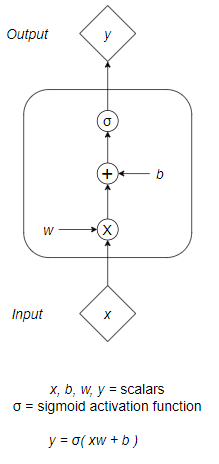



Hyperplane
- But the neural network usually doesn't make a line, or a plane
- Instead, with all the many `w` and `b` parameters we say a **hyperplane** is made
- Note its not flat: the activiation function makes neurons **non-linear**

Parameter Optimization
- How do we choose the right `w`s and `b`s to minimize mean squared error?
- Minimize (optimize) the mean squared error!
- Using a combination of two methods:

1. **gradient descent**
<img src="https://i.pinimg.com/originals/0c/e9/07/0ce90753f7605cc0b26c0e96597ae9e2.gif" width=600>

1. **backpropagation of errors**
<img src="https://robodk.com/blog/wp-content/uploads/2023/11/NeuralNetwork-Training.gif" width=600>




Excellent video explanation: [3 Brown 1 Blue - What is Backpropagation Really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

## Single Neuron

Weights: [array([[2.89961463]]), array([[6.03426891]])]
Biases: [array([7.34457063]), array([4.6722946])]
Number of iterations: 11062
Loss: 0.48096401678015255
Best loss: 0.48096401678015255
Number of layers: 3
Number of outputs: 1

Mean Squared Error (train): 0.8377066191160575
Mean Squared Error: (test) 2.0412211695160543


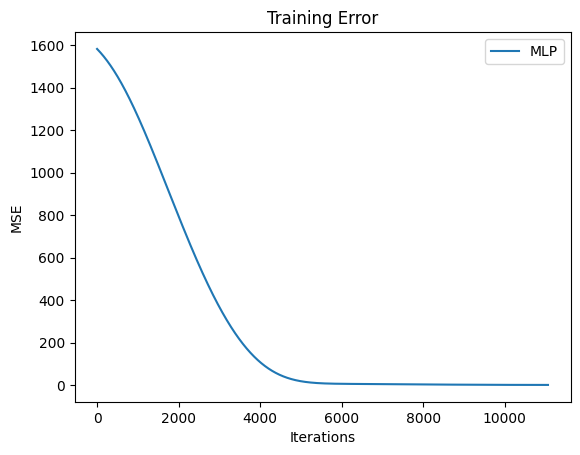

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:24].copy()
y = data['price actual'][:24].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(1,),
                   max_iter=100000,
                   random_state=42,
                   #early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

Plotting function:

In [48]:
def plot_scatter_mlp(df,
                      x='price day ahead',
                      y='price actual',
                      ymlp='price mlp fit',
                      show_errors=False,
                      limit=12):
    df = df[:limit].sort_values(x).copy()

    f = df.plot(x=x,y=y,kind='scatter',label='data',title=f'Scatter Plot (first {limit} h)',xlabel=x+' (x)',ylabel=y+' (y)')  
    if ymlp in df.columns:
        f.plot(df[x],df[ymlp],label='mlp fit',color='red',)    
        f.title.set_text(f'Scatter Plot with MLP Fit')
    if show_errors:
        label=None
        for i,(_x,_y,_yp) in enumerate(zip(df[x],df[y],df[ymlp])):
            if i == len(df[x])-1:
                label = 'errors'
            f.plot([_x, _x], [_y, _yp], color='green', linestyle='-', linewidth=1,label=label,)
        mse = ((df[y]-df[ymlp])**2).mean()
        f.title.set_text(f'Mean of squared errors: {mse:.2f}')
    f.legend()

On the first 12 hours it basically finds the same line as the linear regression.

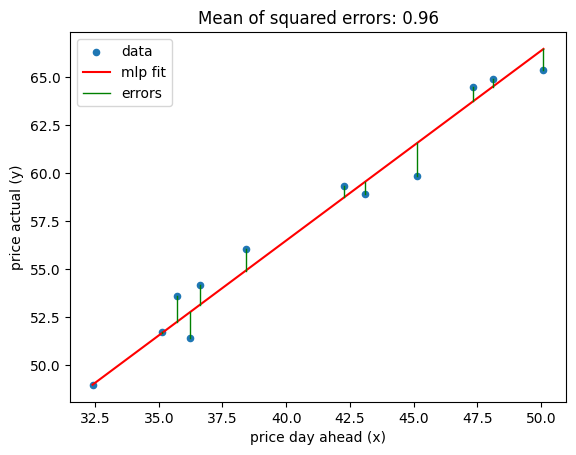

In [49]:
plot_scatter_mlp(train,show_errors=True)

The next 12 hour **forecast** is a little worse than the regression.

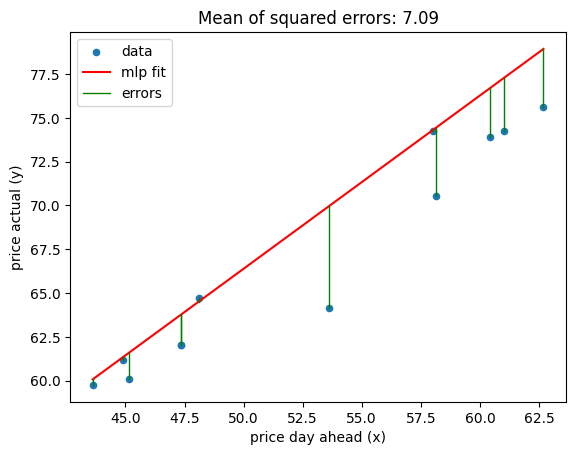

In [50]:
plot_scatter_mlp(test,show_errors=True)

Why? A single neuron basically makes a line, but not a true line because of the activation function. 

We need more neurons.

## Neural Network

The power of a neural network is in the network. This one is:
- Layer 1: 100 neurons
- Layer 2: 10 neurons

Weights: [array([[-5.08041679e-36,  5.68822679e-01,  9.57170035e-02,
         1.27756984e-02,  2.13628823e-02, -1.71044535e-23,
        -5.20097469e-15,  5.05502200e-01, -7.01091311e-36,
        -2.62543007e-32, -1.08250852e-12,  5.73676204e-01,
         5.15141836e-01, -8.49121719e-02, -1.13475307e+00,
        -2.93279004e-01,  2.05802304e-01,  6.52445515e-37,
         2.78536669e-01, -1.12368294e-01,  3.31183374e-01,
         1.50972701e-01,  2.64533926e-32,  8.08039614e-36,
         5.98005438e-37,  4.81717912e-01,  1.68683828e-01,
         3.29484752e-01,  5.07653587e-36, -3.58220762e-14,
         3.71156637e-01,  9.58550483e-25, -1.33356504e-15,
         5.12923808e-01,  5.57528621e-01,  5.04358426e-01,
         6.88679602e-33,  1.45299949e-01,  4.25350606e-01,
         3.01154087e-01, -4.89242733e-01, -2.84508144e-38,
        -1.97628224e-13,  1.43316924e-01, -1.25186712e-30,
        -3.48028484e-34, -1.34381610e-01, -4.43963415e-03,
         2.92688103e-37, -8.47901137e-27,  3.0

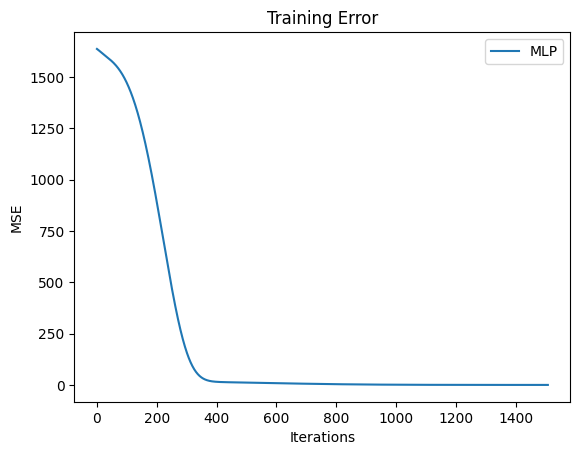

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:24].copy()
y = data['price actual'][:24].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   #early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

Some improvement! But it's not exactly "the promise of AI"

The problem is:
- the model is big (thousands of parameters)
- the data are few (one input value, 12 values total)

### More data: 1000 h

A large part of the "promise of AI" depends on having lots of data

Same model, more data

Weights: [array([[-5.28326450e-07,  7.51179198e-01,  9.95569144e-02,
         1.38733838e-02,  2.39039451e-01, -1.20002925e-02,
        -3.26887672e-02,  6.67199477e-01, -1.30431900e-09,
         4.83618395e-04, -4.28907550e-02,  7.36193995e-01,
         6.91767430e-01,  1.66001538e-01, -1.80971111e-01,
        -2.27189892e-01,  3.71630536e-01,  3.03444657e-14,
         4.54947292e-01, -1.19855595e-01,  5.35454399e-01,
         3.40426135e-01, -4.79224412e-04, -1.85271958e-06,
         1.56124457e-13,  6.60158026e-01,  3.35573151e-01,
         5.01505133e-01, -6.44641242e-11, -2.24363021e-01,
         5.32402886e-01, -9.79076260e-03, -3.09166584e-02,
         6.98950705e-01,  7.27410835e-01,  6.84780042e-01,
        -1.08761035e-01,  3.11103392e-01,  6.26804295e-01,
         4.93954200e-01, -2.85153406e-01, -2.43554098e-15,
        -3.90101216e-02,  1.46422640e-01, -1.55624503e-03,
         3.60006492e-05, -1.20369267e-01, -4.25668011e-03,
         6.08096511e-15, -7.85006392e-03,  5.4

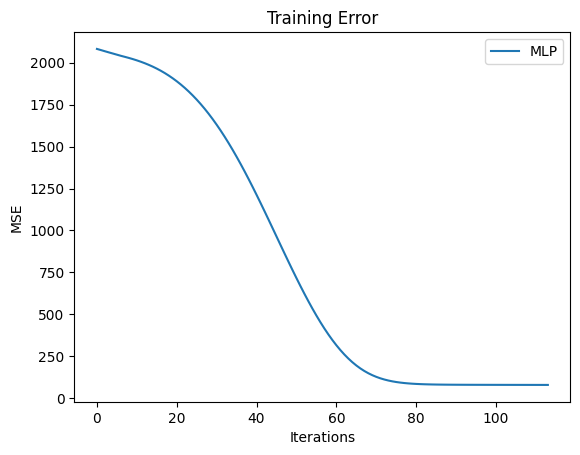

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:1000].copy()
y = data['price actual'][:1000].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

### All Data

The best results will come with all the data and all the features (inputs)

Weights: [array([[ 2.42123790e-002,  1.40553000e-316, -1.05613715e-002, ...,
        -2.90384253e-001, -3.74000035e-001, -3.12014805e-001],
       [-5.29281577e-001,  8.05820574e-318, -1.28919997e-001, ...,
         1.52252378e-001,  7.52172692e-002,  6.01213952e-002],
       [ 4.24347545e-001, -4.42662068e-317,  1.04160888e-001, ...,
         1.10244092e+000,  2.63038187e-001,  4.72221029e-002],
       ...,
       [ 1.21844490e-001,  1.73818144e-316,  1.03757341e-001, ...,
        -1.41987643e-001, -6.42426992e-002, -5.72351535e-002],
       [ 1.13892162e+000, -1.46384675e-316,  3.65280273e-003, ...,
        -1.64351867e-001, -1.39037521e-002,  1.73701198e-001],
       [ 9.59082249e-001,  1.97059649e-316,  1.85975856e-001, ...,
        -1.89725268e-001, -1.47294248e-001, -5.05838484e-002]]), array([[ 8.31018236e-001, -2.35054599e-002,  5.51517295e-001,
        -2.18530546e-316, -1.21854976e-064,  6.26296632e-001,
         8.77232208e-001,  9.60411047e-317,  8.65907273e-214,
         1

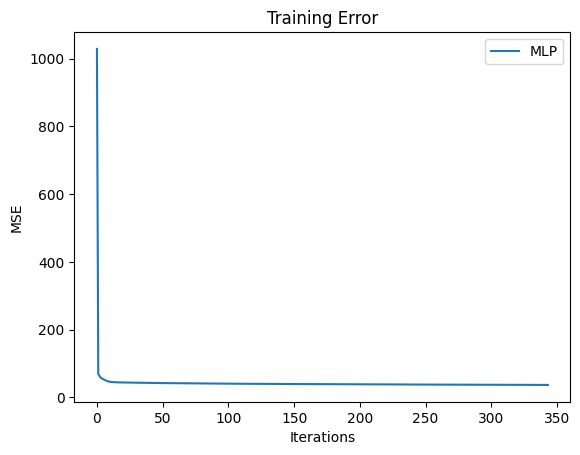

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
cols = data.columns.to_list()
cols.remove('price actual')
X = data[cols].copy()
y = data['price actual'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');